<a href="https://colab.research.google.com/github/MauriAleman35/Modelos-ERP-Ecommerce/blob/main/ModeloLinealProductos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datos cargados exitosamente:
Ventas: 5007 registros
Detalles de venta: 11100 registros
Productos: 200 registros
Categorías: 24 categorías
Dataset unificado creado con 11100 registros y 25 columnas

Primeras filas del dataset:


,_id_detalle,cliente,venta,producto,variedad,cantidad,precio,createdAT_detalle,__v,estado,estado_,_id,createdAT,_id_producto,producto_nombre,categoria,_id_categoria,categoria_nombre,fecha,año,mes,mes_nombre,semana_año,dia_semana,fin_semana
0,68045a2499e4b492e4ec985e,680450bf24880247e3b6d6fd,68045a2499e4b492e4ec985d,68044757e58fe4e2192f1cf5,68044757e58fe4e2192f1cf7,3,126,2024-07-03 09:11:23.094,0,NaN,NaN,68045a2499e4b492e4ec985d,2024-07-03 09:11:23,68044757e58fe4e2192f1cf5,Lonchera Princess Max 606,680446d22a16ea324e2a7db2,680446d22a16ea324e2a7db2,Accesorios (niña),2024-07-03,2024,7,July,27,2,0
1,68045a2499e4b492e4ec9860,680450bf24880247e3b6d6fe,68045a2499e4b492e4ec985f,68044757e58fe4e2192f2208,68044757e58fe4e2192f2210,1,171,2024-07-03 08:55:32.014,0,True,Confirmado,68045a2499e4b492e4ec985f,2024-07-03 08:55:32,68044757e58fe4e2192f2208,Tenis Jogging 2.0 439,680446d22a16ea324e2a7db8,680446d22a16ea324e2a7db8,Calzado F,2024-07-03,2024,7,July,27,2,0
2,68045a2599e4b492e4ec9861,680450bf24880247e3b6d6fe,68045a2499e4b492e4ec985f,68044757e58fe4e2192f1ef7,68044757e58fe4e2192f1efa,1,162,2024-07-03 08:55:32.020,0,True,Confirmado,68045a2499e4b492e4ec985f,2024-07-03 08:55:32,68044757e58fe4e2192f1ef7,Mochila Premium Lite 933,680446d22a16ea324e2a7dbf,680446d22a16ea324e2a7dbf,Colecciones Especiales M,2024-07-03,2024,7,July,27,2,0
3,68045a2599e4b492e4ec9862,680450bf24880247e3b6d6fe,68045a2499e4b492e4ec985f,68044757e58fe4e2192f1f93,68044757e58fe4e2192f1f9b,2,140,2024-07-03 08:55:32.004,0,True,Confirmado,68045a2499e4b492e4ec985f,2024-07-03 08:55:32,68044757e58fe4e2192f1f93,Pantalón Sweet Plus 139,680446d22a16ea324e2a7db6,680446d22a16ea324e2a7db6,Ropa (niña),2024-07-03,2024,7,July,27,2,0
4,68045a2599e4b492e4ec9864,680450bf24880247e3b6d6ff,68045a2599e4b492e4ec9863,68044757e58fe4e2192f1cc8,68044757e58fe4e2192f1ccb,1,111,2024-07-04 18:41:04.027,0,True,Confirmado,68045a2599e4b492e4ec9863,2024-07-04 18:41:04,68044757e58fe4e2192f1cc8,Estuche Triple Pro 879,680446d22a16ea324e2a7db1,680446d22a16ea324e2a7db1,Accesorios (niño),2024-07-04,2024,7,July,27,3,0



=== TOP CATEGORÍAS POR VENTAS ===


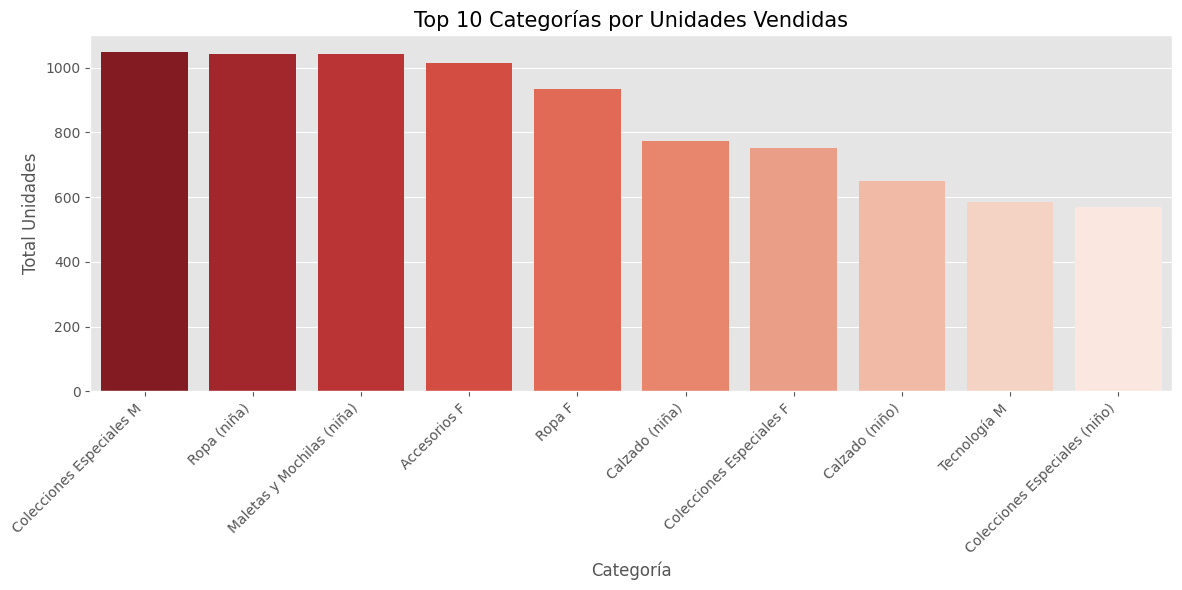


=== TOP PRODUCTOS POR VENTAS ===


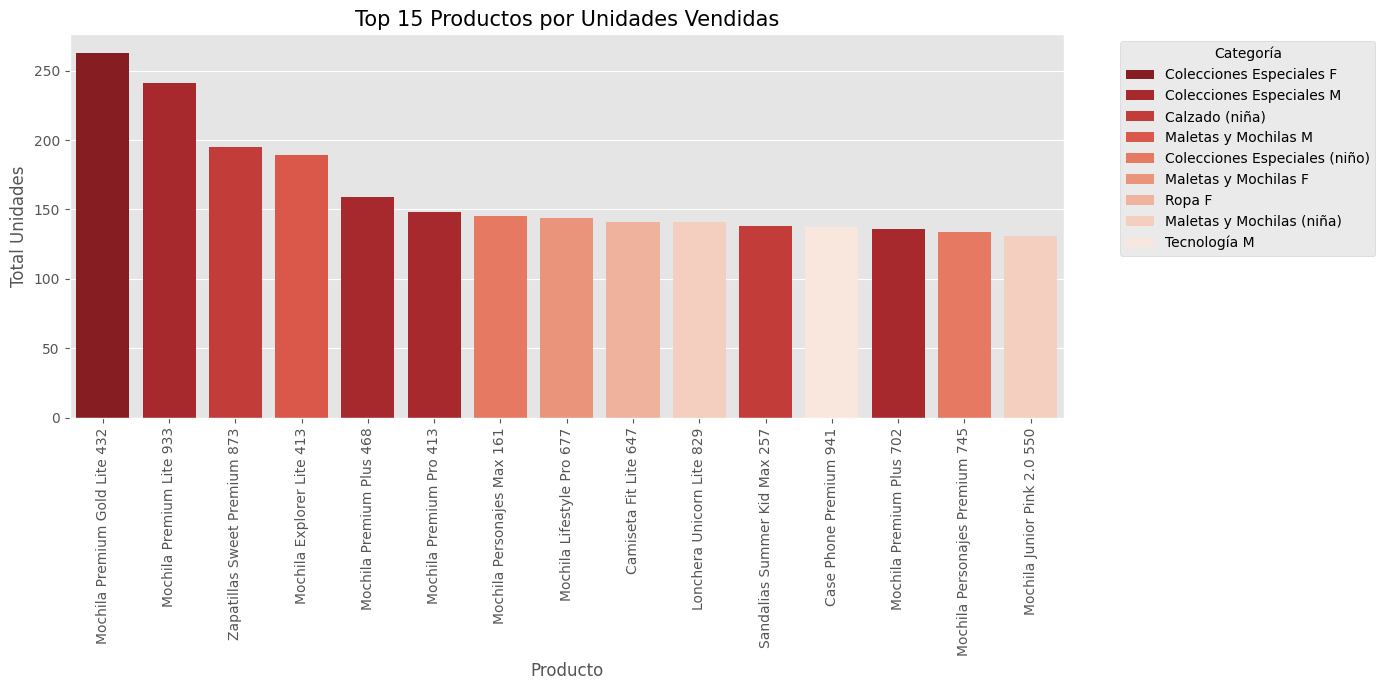


=== ESTACIONALIDAD DE VENTAS ===


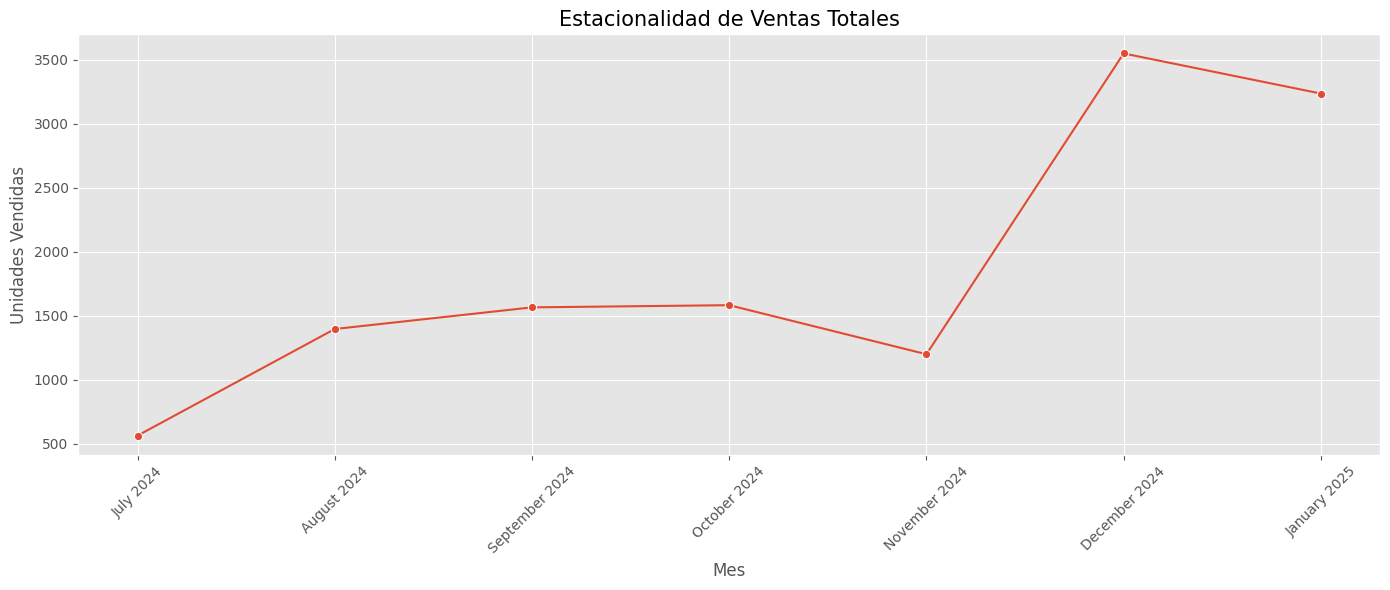


Analizando estacionalidad para: Colecciones Especiales M


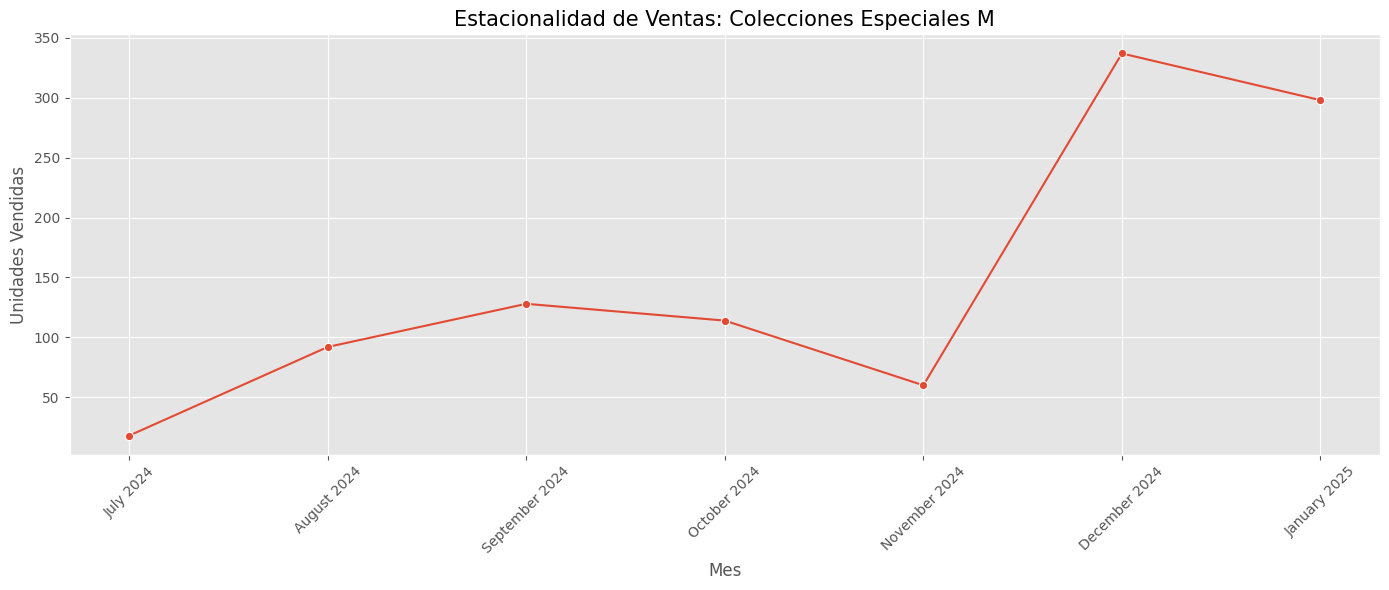

In [10]:
# Predicción Jerárquica de Demanda por Categoría y Producto
# Sistema de Recomendación para Inventario

# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import calendar
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
# Carga de datasets
def cargar_datos():
    """
    Carga los archivos CSV necesarios para el análisis
    """
    try:
        ventas = pd.read_csv('ventas.csv')
        ventadetalles = pd.read_csv('ventadetalles.csv')
        productos = pd.read_csv('productos.csv')
        categorias = pd.read_csv('categorias.csv')

        # Convertir fechas
        ventas['createdAT'] = pd.to_datetime(ventas['createdAT'])
        ventadetalles['createdAT'] = pd.to_datetime(ventadetalles['createdAT'])

        print(f"Datos cargados exitosamente:")
        print(f"Ventas: {ventas.shape[0]} registros")
        print(f"Detalles de venta: {ventadetalles.shape[0]} registros")
        print(f"Productos: {productos.shape[0]} registros")
        print(f"Categorías: {categorias.shape[0]} categorías")

        return ventas, ventadetalles, productos, categorias
    except Exception as e:
        print(f"Error al cargar los datos: {e}")
        return None, None, None, None

# Fusionar las tablas para crear el dataset principal
def crear_dataset_principal(ventas, ventadetalles, productos, categorias):
    """
    Une las tablas para crear un dataset integrado de ventas con categorías
    """
    # Filtramos solo ventas completadas
    ventas_validas = ventas[ventas['estado'].isin(['Confirmado', 'Procesado'])]

    # Unir ventadetalles con ventas
    ventas_detalladas = pd.merge(
        ventadetalles,
        ventas_validas[['_id', 'createdAT']],
        left_on='venta',
        right_on='_id',
        suffixes=('_detalle', '')
    )

    # Unir con productos
    ventas_con_productos = pd.merge(
        ventas_detalladas,
        productos[['_id', 'titulo', 'categoria']],
        left_on='producto',
        right_on='_id',
        suffixes=('', '_producto')
    ).rename(columns={'titulo': 'producto_nombre'})

    # Unir con categorías
    ventas_completas = pd.merge(
        ventas_con_productos,
        categorias[['_id', 'titulo']],
        left_on='categoria',
        right_on='_id',
        suffixes=('', '_categoria')
    ).rename(columns={'titulo': 'categoria_nombre'})

    # Crear variables temporales
    ventas_completas['fecha'] = ventas_completas['createdAT'].dt.date
    ventas_completas['año'] = ventas_completas['createdAT'].dt.year
    ventas_completas['mes'] = ventas_completas['createdAT'].dt.month
    ventas_completas['mes_nombre'] = ventas_completas['createdAT'].dt.strftime('%B')
    ventas_completas['semana_año'] = ventas_completas['createdAT'].dt.isocalendar().week
    ventas_completas['dia_semana'] = ventas_completas['createdAT'].dt.dayofweek
    ventas_completas['fin_semana'] = ventas_completas['dia_semana'].isin([5, 6]).astype(int)

    print(f"Dataset unificado creado con {ventas_completas.shape[0]} registros y {ventas_completas.shape[1]} columnas")
    return ventas_completas

# Cargar los datos
ventas, ventadetalles, productos, categorias = cargar_datos()

if ventas is not None:
    # Crear dataset principal
    dataset_ventas = crear_dataset_principal(ventas, ventadetalles, productos, categorias)

    # Mostrar las primeras filas
    print("\nPrimeras filas del dataset:")
    display(dataset_ventas.head())

# Análisis de ventas por categoría
def analizar_top_categorias(dataset, n=10, visualizar=True):
    """
    Identifica y visualiza las categorías con mayor volumen de ventas
    """
    # Agrupar por categoría y calcular métricas
    ventas_por_categoria = dataset.groupby('categoria_nombre').agg(
        total_unidades=('cantidad', 'sum'),
        total_ventas=('precio', lambda x: (x * dataset.loc[x.index, 'cantidad']).sum()),
        n_transacciones=('venta', 'nunique'),
        productos_unicos=('producto', 'nunique')
    ).reset_index()

    # Ordenar por total de unidades
    top_categorias = ventas_por_categoria.sort_values('total_unidades', ascending=False).head(n)

    if visualizar:
        plt.figure(figsize=(12, 6))
        sns.barplot(x='categoria_nombre', y='total_unidades', data=top_categorias,
                   palette='Reds_r')
        plt.title(f'Top {n} Categorías por Unidades Vendidas', fontsize=15)
        plt.xlabel('Categoría')
        plt.ylabel('Total Unidades')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    return top_categorias

# Análisis de ventas por producto
def analizar_top_productos(dataset, n=20, visualizar=True):
    """
    Identifica y visualiza los productos con mayor volumen de ventas
    """
    # Agrupar por producto
    ventas_por_producto = dataset.groupby(['producto_nombre', 'categoria_nombre']).agg(
        total_unidades=('cantidad', 'sum'),
        total_ventas=('precio', lambda x: (x * dataset.loc[x.index, 'cantidad']).sum()),
        n_transacciones=('venta', 'nunique')
    ).reset_index()

    # Ordenar por total de unidades
    top_productos = ventas_por_producto.sort_values('total_unidades', ascending=False).head(n)

    if visualizar:
        plt.figure(figsize=(14, 7))
        sns.barplot(x='producto_nombre', y='total_unidades', hue='categoria_nombre',
                   data=top_productos, dodge=False, palette='Reds_r')
        plt.title(f'Top {n} Productos por Unidades Vendidas', fontsize=15)
        plt.xlabel('Producto')
        plt.ylabel('Total Unidades')
        plt.xticks(rotation=90)
        plt.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    return top_productos

# Análisis de estacionalidad por categoría
def analizar_estacionalidad(dataset, categoria=None):
    """
    Analiza patrones estacionales en las ventas (mensuales)
    """
    # Filtrar por categoría si se especifica
    if categoria:
        data = dataset[dataset['categoria_nombre'] == categoria].copy()
        titulo = f'Estacionalidad de Ventas: {categoria}'
    else:
        data = dataset.copy()
        titulo = 'Estacionalidad de Ventas Totales'

    # Agrupar por mes
    ventas_mensuales = data.groupby(['año', 'mes']).agg(
        total_unidades=('cantidad', 'sum'),
        mes_nombre=('mes_nombre', 'first')
    ).reset_index()

    # Crear etiqueta de mes-año para visualización
    ventas_mensuales['periodo'] = ventas_mensuales['mes_nombre'] + ' ' + ventas_mensuales['año'].astype(str)

    # Visualizar
    plt.figure(figsize=(14, 6))
    sns.lineplot(x='periodo', y='total_unidades', data=ventas_mensuales, marker='o')
    plt.title(titulo, fontsize=15)
    plt.xlabel('Mes')
    plt.ylabel('Unidades Vendidas')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return ventas_mensuales

# Ejecutar los análisis si el dataset está disponible
if 'dataset_ventas' in locals():
    # Análisis de categorías
    print("\n=== TOP CATEGORÍAS POR VENTAS ===")
    top_categorias = analizar_top_categorias(dataset_ventas)

    # Análisis de productos
    print("\n=== TOP PRODUCTOS POR VENTAS ===")
    top_productos = analizar_top_productos(dataset_ventas, n=15)

    # Análisis de estacionalidad
    print("\n=== ESTACIONALIDAD DE VENTAS ===")
    # Estacionalidad general
    estacionalidad_general = analizar_estacionalidad(dataset_ventas)

    # Estacionalidad para la categoría más vendida
    if not top_categorias.empty:
        categoria_principal = top_categorias.iloc[0]['categoria_nombre']
        print(f"\nAnalizando estacionalidad para: {categoria_principal}")
        estacionalidad_categoria = analizar_estacionalidad(dataset_ventas, categoria_principal)

In [17]:
# Preparación de datos para modelado por categoría
def preparar_datos_categoria(dataset, categoria):
    """
    Prepara dataset para modelar ventas de una categoría específica
    """
    # Filtrar para la categoría seleccionada
    data_categoria = dataset[dataset['categoria_nombre'] == categoria].copy()

    # Agregar por fecha
    ventas_diarias = data_categoria.groupby('fecha').agg(
        total_unidades=('cantidad', 'sum')
    ).reset_index()

    # Convertir fecha a datetime explícitamente
    ventas_diarias['fecha'] = pd.to_datetime(ventas_diarias['fecha'])

    # Asegurar que tenemos datos para todos los días (llenar con ceros los días sin ventas)
    fecha_min = ventas_diarias['fecha'].min()
    fecha_max = ventas_diarias['fecha'].max()

    # Crear rango completo de fechas
    todas_fechas = pd.DataFrame({
        'fecha': pd.date_range(start=fecha_min, end=fecha_max, freq='D')
    })

    # Combinar con datos reales
    ventas_completas = pd.merge(todas_fechas, ventas_diarias, on='fecha', how='left')
    ventas_completas['total_unidades'] = ventas_completas['total_unidades'].fillna(0)

    # Convertir fecha a datetime si no lo está
    if not pd.api.types.is_datetime64_dtype(ventas_completas['fecha']):
        ventas_completas['fecha'] = pd.to_datetime(ventas_completas['fecha'])

    # Crear variables temporales
    ventas_completas['año'] = ventas_completas['fecha'].dt.year
    ventas_completas['mes'] = ventas_completas['fecha'].dt.month
    ventas_completas['dia_año'] = ventas_completas['fecha'].dt.dayofyear
    ventas_completas['dia_semana'] = ventas_completas['fecha'].dt.dayofweek
    ventas_completas['fin_semana'] = ventas_completas['dia_semana'].isin([5, 6]).astype(int)

    # Variables rezagadas (lag)
    for lag in [1, 3, 7, 14, 28]:
        ventas_completas[f'lag_{lag}d'] = ventas_completas['total_unidades'].shift(lag)

    # Media móvil
    for window in [7, 14, 30]:
        ventas_completas[f'ma_{window}d'] = ventas_completas['total_unidades'].rolling(window=window, min_periods=1).mean()

    # Eliminar filas con NaN
    ventas_completas = ventas_completas.dropna()

    return ventas_completas

# Función para entrenar modelo por categoría
def entrenar_modelo_categoria(datos_categoria):
    """
    Entrena un modelo de predicción para una categoría específica
    """
    # Variables predictoras y objetivo
    X = datos_categoria.drop(['fecha', 'total_unidades'], axis=1)
    y = datos_categoria['total_unidades']

    # Si tenemos pocos datos, no modelar
    if len(X) < 30:
        print("  Insuficientes datos para modelado confiable")
        return None, None, None

    # División en entrenamiento y prueba (80-20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Entrenar modelo
    modelo = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo.fit(X_train, y_train)

    # Evaluar modelo
    y_pred = modelo.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"  Métricas: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.2f}")

    return modelo, X_test, y_test

# Distribución de ventas por producto dentro de una categoría
def calcular_distribucion_productos(dataset, categoria):
    """
    Calcula la distribución histórica de ventas entre productos de una categoría
    """
    # Filtrar para la categoría
    data_cat = dataset[dataset['categoria_nombre'] == categoria].copy()

    # Calcular total de unidades vendidas por categoría
    total_categoria = data_cat['cantidad'].sum()

    if total_categoria == 0:
        return pd.DataFrame()

    # Agrupar por producto
    productos_distribucion = data_cat.groupby('producto_nombre').agg(
        unidades_vendidas=('cantidad', 'sum'),
        ultima_venta=('createdAT', 'max'),
        precio_promedio=('precio', 'mean')
    ).reset_index()

    # Calcular porcentaje de contribución y clasificar por popularidad
    productos_distribucion['porcentaje'] = (productos_distribucion['unidades_vendidas'] / total_categoria) * 100
    productos_distribucion['recencia'] = (datetime.now() - productos_distribucion['ultima_venta']).dt.days

    # Ordenar por unidades vendidas
    productos_distribucion = productos_distribucion.sort_values('unidades_vendidas', ascending=False)

    return productos_distribucion

# Función para entrenar modelos para todas las categorías relevantes
def entrenar_modelos_todas_categorias(dataset, min_ventas=100):
    """
    Entrena modelos para todas las categorías con suficientes datos
    """
    # Identificar categorías con suficientes datos
    ventas_por_categoria = dataset.groupby('categoria_nombre')['cantidad'].sum()
    categorias_relevantes = ventas_por_categoria[ventas_por_categoria >= min_ventas].index.tolist()

    print(f"Entrenando modelos para {len(categorias_relevantes)} categorías:")

    # Diccionario para almacenar modelos y datos asociados
    modelos = {}

    for categoria in categorias_relevantes:
        print(f"\nProcesando: {categoria}")

        # Preparar datos
        datos_categoria = preparar_datos_categoria(dataset, categoria)

        # Entrenar modelo
        modelo, X_test, y_test = entrenar_modelo_categoria(datos_categoria)

        if modelo:
            # Calcular distribución de productos
            distribucion = calcular_distribucion_productos(dataset, categoria)

            # Guardar modelo y datos asociados
            modelos[categoria] = {
                'modelo': modelo,
                'datos_test': (X_test, y_test),
                'distribucion_productos': distribucion,
                'ultima_fecha': datos_categoria['fecha'].max()
            }

    print(f"\nModelos entrenados exitosamente: {len(modelos)}/{len(categorias_relevantes)}")
    return modelos

# Ejecutar entrenamiento de modelos
if 'dataset_ventas' in locals():
    print("\n=== ENTRENAMIENTO DE MODELOS POR CATEGORÍA ===")
    modelos_por_categoria = entrenar_modelos_todas_categorias(dataset_ventas)

# Función principal de predicción
def predecir_demanda(categoria, num_meses=3, modelos=None, dataset=None, mostrar_productos=True):
    """
    Función principal para predecir demanda por categoría y opcionalmente productos
    """
    if modelos is None or dataset is None:
        print("Error: Modelos y dataset son necesarios para la predicción")
        return None

    # Comprobar si la categoría está disponible
    if categoria not in modelos:
        print(f"No hay modelo disponible para: {categoria}")
        print(f"Categorías disponibles: {list(modelos.keys())}")
        return None

    print(f"\n=== PREDICCIÓN DE DEMANDA: {categoria} ===")
    print(f"Período: Próximos {num_meses} meses")

    # Predicción por categoría
    prediccion_categoria = predecir_demanda_categoria(categoria, num_meses, modelos, dataset)

    if prediccion_categoria is None:
        return None

    # Visualizar predicción mensual
    plt.figure(figsize=(12, 6))

    # Crear etiquetas de mes-año
    labels_meses = [f"{row['mes_nombre']} {row['año']}" for _, row in prediccion_categoria.iterrows()]

    # Visualizar con barras
    plt.bar(labels_meses, prediccion_categoria['demanda_predicha'], color='indianred', alpha=0.7)

    # Añadir intervalo de confianza
    for i, (_, row) in enumerate(prediccion_categoria.iterrows()):
        plt.plot([i, i], [row['rango_inferior'], row['rango_superior']],
                color='black', linewidth=2)

    plt.title(f'Predicción de Demanda: {categoria}', fontsize=15)
    plt.xlabel('Mes')
    plt.ylabel('Unidades Predichas')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Mostrar tabla resumen de predicción mensual
    print("\nPredicción Mensual:")
    display(prediccion_categoria[['año', 'mes_nombre', 'demanda_predicha', 'rango_inferior', 'rango_superior']])

    # Si se solicita, predecir por producto
    if mostrar_productos:
        prediccion_productos = predecir_demanda_productos(categoria, prediccion_categoria, modelos)

        if prediccion_productos is not None and not prediccion_productos.empty:
            # Agrupar productos por mes para visualizar top productos
            top_productos_por_mes = {}

            for mes in labels_meses:
                año, mes_nombre = mes.split(' ')
                productos_mes = prediccion_productos[
                    (prediccion_productos['año'] == int(año)) &
                    (prediccion_productos['mes_nombre'] == mes_nombre)
                ]

                # Ordenar por demanda predicha
                productos_mes = productos_mes.sort_values('demanda_predicha', ascending=False)

                # Guardar top 10
                top_productos_por_mes[mes] = productos_mes.head(10)

            # Mostrar top productos para el primer mes (como ejemplo)
            primer_mes = labels_meses[0]
            print(f"\nTop 10 Productos Predichos para {primer_mes}:")
            display(top_productos_por_mes[primer_mes][['producto', 'demanda_predicha', 'valor_estimado']])

            # Visualizar distribución de productos para el primer mes
            plt.figure(figsize=(14, 7))
            top_df = top_productos_por_mes[primer_mes].head(10)
            sns.barplot(x='producto', y='demanda_predicha', data=top_df, palette='Reds_r')
            plt.title(f'Top 10 Productos Predichos - {primer_mes}', fontsize=15)
            plt.xlabel('Producto')
            plt.ylabel('Unidades Predichas')
            plt.xticks(rotation=90)
            plt.tight_layout()
            plt.show()

            return {
                'prediccion_categoria': prediccion_categoria,
                'prediccion_productos': prediccion_productos
            }

    return {'prediccion_categoria': prediccion_categoria}

# Función para distribuir la demanda entre productos de una categoría
def predecir_demanda_productos(categoria, prediccion_categoria, modelos):
    """
    Distribuye la predicción de la categoría entre los productos individuales
    """
    if categoria not in modelos:
        print(f"No hay datos para la categoría: {categoria}")
        return None

    # Obtener distribución de productos
    distribucion = modelos[categoria]['distribucion_productos']

    if distribucion.empty:
        print(f"No hay datos de distribución para productos de la categoría: {categoria}")
        return None

    # Lista para predicciones por producto
    predicciones_productos = []

    # Para cada mes en la predicción
    for _, pred_mes in prediccion_categoria.iterrows():
        demanda_mes = pred_mes['demanda_predicha']

        # Para cada producto en la distribución
        for _, producto in distribucion.iterrows():
            # Calcular demanda por producto basada en porcentaje histórico
            demanda_producto = (demanda_mes * producto['porcentaje'] / 100)

            # Aplicar factor de recencia (productos más recientes pueden tener más demanda)
            factor_recencia = 1.0
            if producto['recencia'] < 30:
                factor_recencia = 1.2  # Boost para productos vendidos en el último mes
            elif producto['recencia'] > 90:
                factor_recencia = 0.8  # Reducción para productos sin venta en 90+ días

            demanda_producto = demanda_producto * factor_recencia

            # Redondear y asegurar valores positivos
            demanda_producto = max(0, round(demanda_producto))

            # Guardar predicción
            predicciones_productos.append({
                'año': pred_mes['año'],
                'mes': pred_mes['mes'],
                'mes_nombre': pred_mes['mes_nombre'],
                'categoria': categoria,
                'producto': producto['producto_nombre'],
                'demanda_predicha': demanda_producto,
                'precio_estimado': producto['precio_promedio'],
                'valor_estimado': demanda_producto * producto['precio_promedio']
            })

    return pd.DataFrame(predicciones_productos)

# Función principal de predicción
def predecir_demanda(categoria, num_meses=3, modelos=None, dataset=None, mostrar_productos=True):
    """
    Función principal para predecir demanda por categoría y opcionalmente productos
    """
    if modelos is None or dataset is None:
        print("Error: Modelos y dataset son necesarios para la predicción")
        return None

    # Comprobar si la categoría está disponible
    if categoria not in modelos:
        print(f"No hay modelo disponible para: {categoria}")
        print(f"Categorías disponibles: {list(modelos.keys())}")
        return None

    print(f"\n=== PREDICCIÓN DE DEMANDA: {categoria} ===")
    print(f"Período: Próximos {num_meses} meses")

    # Predicción por categoría
    prediccion_categoria = predecir_demanda_categoria(categoria, num_meses, modelos, dataset)

    if prediccion_categoria is None:
        return None

    # Visualizar predicción mensual
    plt.figure(figsize=(12, 6))

    # Crear etiquetas de mes-año
    labels_meses = [f"{row['mes_nombre']} {row['año']}" for _, row in prediccion_categoria.iterrows()]

    # Visualizar con barras
    plt.bar(labels_meses, prediccion_categoria['demanda_predicha'], color='indianred', alpha=0.7)

    # Añadir intervalo de confianza
    for i, (_, row) in enumerate(prediccion_categoria.iterrows()):
        plt.plot([i, i], [row['rango_inferior'], row['rango_superior']],
                color='black', linewidth=2)

    plt.title(f'Predicción de Demanda: {categoria}', fontsize=15)
    plt.xlabel('Mes')
    plt.ylabel('Unidades Predichas')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Mostrar tabla resumen de predicción mensual
    print("\nPredicción Mensual:")
    display(prediccion_categoria[['año', 'mes_nombre', 'demanda_predicha', 'rango_inferior', 'rango_superior']])

    # Si se solicita, predecir por producto
    if mostrar_productos:
        prediccion_productos = predecir_demanda_productos(categoria, prediccion_categoria, modelos)

        if prediccion_productos is not None:
            # Agrupar productos por mes para visualizar top productos
            top_productos_por_mes = {}

            for mes in labels_meses:
                año, mes_nombre = mes.split(' ')
                productos_mes = prediccion_productos[
                    (prediccion_productos['año'] == int(año)) &
                    (prediccion_productos['mes_nombre'] == mes_nombre)
                ]

                # Ordenar por demanda predicha
                productos_mes = productos_mes.sort_values('demanda_predicha', ascending=False)

                # Guardar top 10
                top_productos_por_mes[mes] = productos_mes.head(10)

            # Mostrar top productos para el primer mes (como ejemplo)
            primer_mes = labels_meses[0]
            print(f"\nTop 10 Productos Predichos para {primer_mes}:")
            display(top_productos_por_mes[primer_mes][['producto', 'demanda_predicha', 'valor_estimado']])

            # Visualizar distribución de productos para el primer mes
            plt.figure(figsize=(14, 7))
            top_df = top_productos_por_mes[primer_mes].head(10)
            sns.barplot(x='producto', y='demanda_predicha', data=top_df, palette='Reds_r')
            plt.title(f'Top 10 Productos Predichos - {primer_mes}', fontsize=15)
            plt.xlabel('Producto')
            plt.ylabel('Unidades Predichas')
            plt.xticks(rotation=90)
            plt.tight_layout()
            plt.show()

            return {
                'prediccion_categoria': prediccion_categoria,
                'prediccion_productos': prediccion_productos
            }

    return {'prediccion_categoria': prediccion_categoria}

# Demostración del sistema
if 'modelos_por_categoria' in locals() and len(modelos_por_categoria) > 0:
    # Obtener categorías disponibles
    categorias_disponibles = list(modelos_por_categoria.keys())
    print(f"\nCategorías disponibles para predicción: {len(categorias_disponibles)}")
    print(categorias_disponibles)

    # Ejecutar predicción para una categoría ejemplo
    if categorias_disponibles:
        # Seleccionar una categoría con buen rendimiento
        categoria_demo = categorias_disponibles[0]  # Primera categoría como ejemplo

        print("\n=== DEMOSTRACIÓN DEL SISTEMA ===")
        print(f"Predicción para categoría: {categoria_demo}")

        # Predecir demanda para los próximos 3 meses
        resultados = predecir_demanda(
            categoria=categoria_demo,
            num_meses=3,
            modelos=modelos_por_categoria,
            dataset=dataset_ventas
        )


=== ENTRENAMIENTO DE MODELOS POR CATEGORÍA ===
Entrenando modelos para 24 categorías:

Procesando: Accesorios (niña)
  Métricas: RMSE=4.63, MAE=3.57, R²=0.08

Procesando: Accesorios (niño)
  Métricas: RMSE=3.02, MAE=2.67, R²=-0.15

Procesando: Accesorios F
  Métricas: RMSE=9.66, MAE=6.76, R²=0.20

Procesando: Accesorios M
  Métricas: RMSE=1.59, MAE=1.17, R²=0.07

Procesando: Calzado (niña)
  Métricas: RMSE=9.51, MAE=8.08, R²=0.23

Procesando: Calzado (niño)
  Métricas: RMSE=6.14, MAE=5.06, R²=0.15

Procesando: Calzado F
  Métricas: RMSE=9.49, MAE=8.72, R²=-2.88

Procesando: Calzado M
  Métricas: RMSE=4.81, MAE=4.28, R²=-0.16

Procesando: Colecciones Especiales (niña)
  Métricas: RMSE=3.29, MAE=2.55, R²=0.01

Procesando: Colecciones Especiales (niño)
  Métricas: RMSE=5.94, MAE=4.66, R²=0.17

Procesando: Colecciones Especiales F
  Métricas: RMSE=11.53, MAE=10.39, R²=-0.57

Procesando: Colecciones Especiales M
  Métricas: RMSE=11.10, MAE=8.02, R²=0.13

Procesando: Maletas y Mochilas (niñ

TypeError: Cannot compare Timestamp with datetime.date. Use ts == pd.Timestamp(date) or ts.date() == date instead.

In [ ]:
# Función para exportar el sistema (modelos y datos relevantes)
def exportar_sistema(modelos, ruta_base='/content'):
    """
    Exporta los modelos y datos relevantes para su implementación
    """
    import pickle

    # Crear diccionario con modelos y metadatos
    sistema = {
        'modelos': {cat: data['modelo'] for cat, data in modelos.items()},
        'distribuciones': {cat: data['distribucion_productos'] for cat, data in modelos.items()},
        'metadatos': {
            'categorias': list(modelos.keys()),
            'fecha_entrenamiento': datetime.now().strftime('%Y-%m-%d'),
            'version': '1.0'
        }
    }

    # Guardar sistema
    ruta_archivo = f"{ruta_base}/sistema_prediccion_demanda.pkl"
    with open(ruta_archivo, 'wb') as f:
        pickle.dump(sistema, f)

    print(f"Sistema exportado exitosamente: {ruta_archivo}")
    print(f"Categorías incluidas: {len(sistema['modelos'])}")

    # Generar código básico para implementación
    codigo_implementacion = """
    # Código para implementar el sistema en producción

    import pickle
    import pandas as pd
    from datetime import datetime

    # Cargar el sistema
    with open('sistema_prediccion_demanda.pkl', 'rb') as f:
        sistema = pickle.load(f)

    def predecir_demanda_api(categoria, num_meses=3):
        '''
        Función para implementar en API
        '''
        if categoria not in sistema['modelos']:
            return {"error": f"Categoría no disponible: {categoria}"}

        # Implementar lógica de predicción similar a predecir_demanda()
        # ...

        return {
            "categoria": categoria,
            "meses": num_meses,
            "predicciones": [
                {"año": 2025, "mes": "Mayo", "demanda": 350},
                # etc...
            ]
        }
    """

    # Guardar código de implementación
    ruta_codigo = f"{ruta_base}/implementacion_api.py"
    with open(ruta_codigo, 'w') as f:
        f.write(codigo_implementacion)

    print(f"\nCódigo de implementación generado: {ruta_codigo}")

# Exportar el sistema si hay modelos entrenados
if 'modelos_por_categoria' in locals() and len(modelos_por_categoria) > 0:
    print("\n=== EXPORTACIÓN DEL SISTEMA ===")
    exportar_sistema(modelos_por_categoria)

Categorías con suficientes datos para modelado: 24
Lista de categorías modelables:
['Maletas y Mochilas (niña)', 'Ropa (niña)', 'Accesorios F', 'Ropa F', 'Colecciones Especiales M', 'Colecciones Especiales F', 'Calzado (niño)', 'Calzado (niña)', 'Accesorios (niña)', 'Tecnología M', 'Calzado F', 'Colecciones Especiales (niño)', 'Maletas y Mochilas M', 'Tecnología (niño)', 'Calzado M', 'Ropa (niño)', 'Maletas y Mochilas F', 'Ropa M', 'Colecciones Especiales (niña)', 'Maletas y Mochilas (niño)', 'Accesorios (niño)', 'Tecnología (niña)', 'Accesorios M', 'Tecnología F']

Modelando: Maletas y Mochilas (niña)
Resultados para Maletas y Mochilas (niña):
RMSE: 11.51, MAE: 6.38, R²: -0.04

Modelando: Ropa (niña)
Resultados para Ropa (niña):
RMSE: 11.20, MAE: 7.07, R²: -0.02

Modelando: Accesorios F
Resultados para Accesorios F:
RMSE: 8.79, MAE: 6.01, R²: 0.31

Modelando: Ropa F
Resultados para Ropa F:
RMSE: 8.36, MAE: 5.68, R²: 0.06

Modelando: Colecciones Especiales M
Resultados para Colecciones

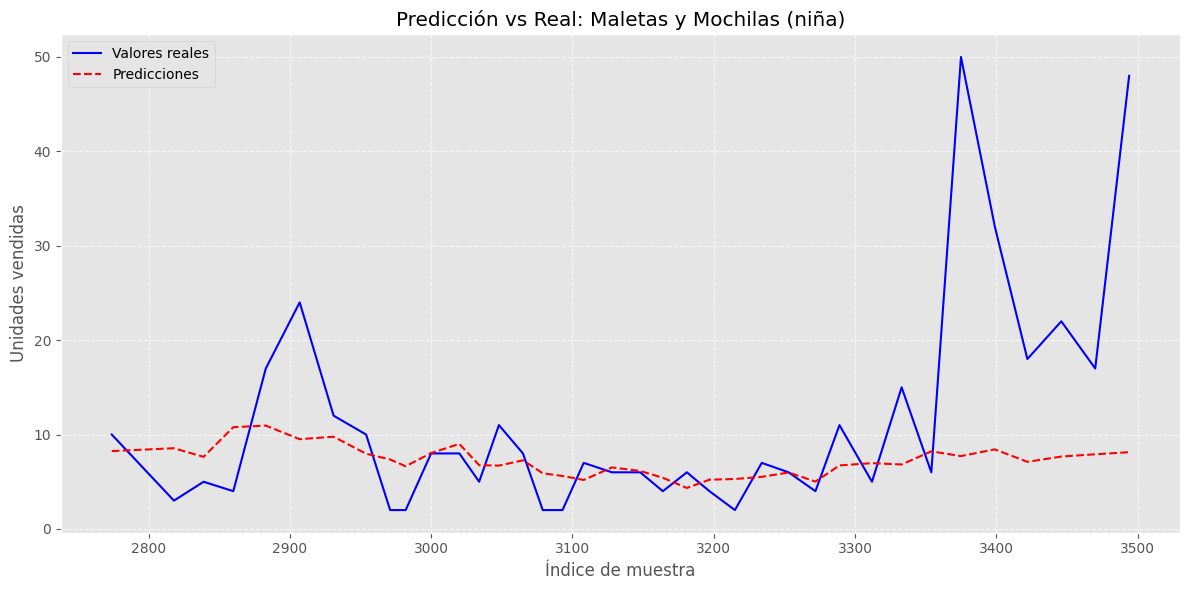

Error porcentual medio: 57.73%


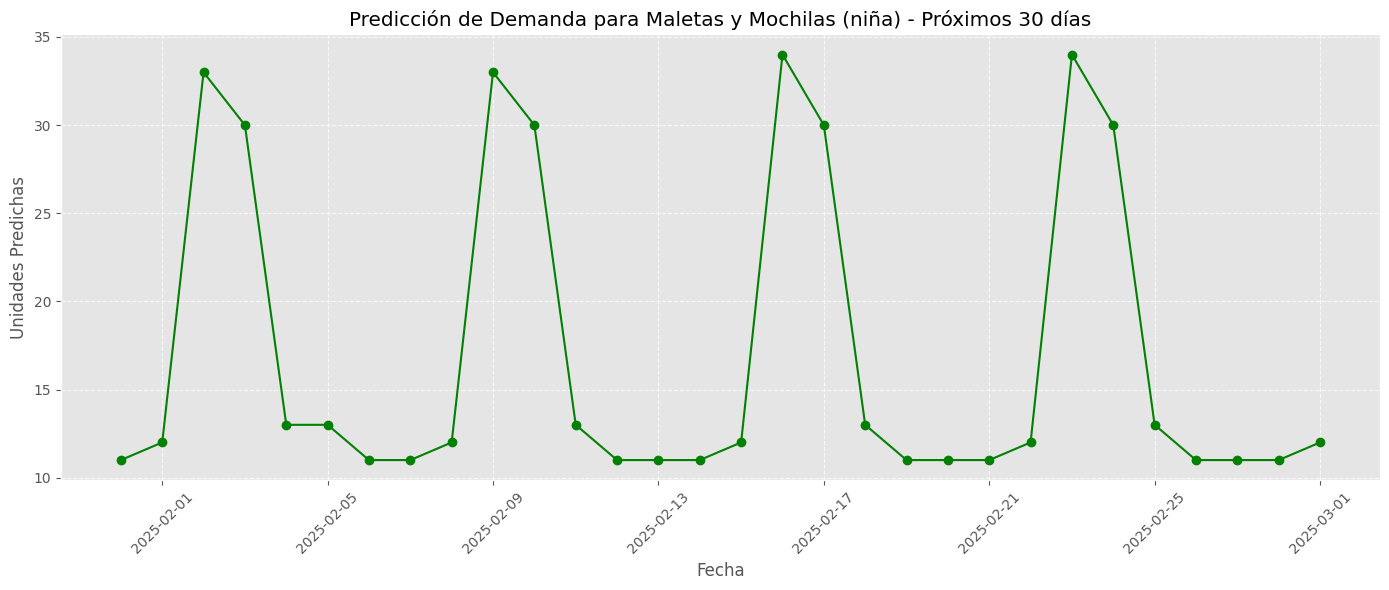


Predicción para los próximos 7 días:
       fecha  demanda_predicha
0 2025-01-31                11
1 2025-02-01                12
2 2025-02-02                33
3 2025-02-03                30
4 2025-02-04                13
5 2025-02-05                13
6 2025-02-06                11


In [3]:
# Seleccionar categorías con suficientes datos para modelado
categorias_modelables = ventas_por_categoria['titulo'].value_counts()
categorias_modelables = categorias_modelables[categorias_modelables > 30].index.tolist()

print(f"Categorías con suficientes datos para modelado: {len(categorias_modelables)}")
print("Lista de categorías modelables:")
print(categorias_modelables)

# Entrenar modelos por categoría
resultados_modelos = {}
for categoria in categorias_modelables[:5]:  # Limitamos a 5 para el ejemplo
    print(f"\nModelando: {categoria}")
    modelo, X_test, y_test = modelar_categoria(categoria)
    if modelo:
        resultados_modelos[categoria] = {
            'modelo': modelo,
            'X_test': X_test,
            'y_test': y_test,
            'y_pred': modelo.predict(X_test)
        }

# Visualizar resultados de predicción para una categoría
def visualizar_prediccion(categoria):
    if categoria not in resultados_modelos:
        print(f"No hay modelo disponible para {categoria}")
        return

    resultado = resultados_modelos[categoria]
    y_test = resultado['y_test']
    y_pred = resultado['y_pred']

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, 'b-', label='Valores reales')
    plt.plot(y_test.index, y_pred, 'r--', label='Predicciones')
    plt.title(f'Predicción vs Real: {categoria}')
    plt.xlabel('Índice de muestra')
    plt.ylabel('Unidades vendidas')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Calcular error porcentual
    error_porcentual = np.abs((y_test - y_pred) / y_test.mean()) * 100
    print(f"Error porcentual medio: {error_porcentual.mean():.2f}%")

# Visualizar una de las categorías modeladas
if len(resultados_modelos) > 0:
    visualizar_prediccion(list(resultados_modelos.keys())[0])

# Función para predecir la demanda futura por categoría
def predecir_demanda_categoria(categoria, dias_futuro=30):
    if categoria not in resultados_modelos:
        print(f"No hay modelo disponible para {categoria}")
        return None

    modelo = resultados_modelos[categoria]['modelo']

    # Obtener los datos más recientes para esa categoría
    df_cat = preparar_dataset_categoria(categoria)
    ultimos_datos = df_cat.iloc[-1:].copy()

    # Lista para almacenar predicciones
    predicciones = []

    # Generar predicciones para días futuros
    fecha_actual = ultimos_datos['fecha'].iloc[0]

    for i in range(1, dias_futuro + 1):
        # Crear nueva fila de datos
        nueva_fecha = fecha_actual + timedelta(days=i)
        nueva_fila = ultimos_datos.copy()

        # Actualizar fecha y características temporales
        nueva_fila['fecha'] = nueva_fecha
        nueva_fila['año'] = nueva_fecha.year
        nueva_fila['dia_año'] = nueva_fecha.dayofyear

        # Actualizar día de la semana (manualmente actualizar las dummy variables)
        dia_semana = nueva_fecha.dayofweek
        for col in nueva_fila.columns:
            if col.startswith('dia_semana_'):
                dia_col = int(col.split('_')[-1])
                nueva_fila[col] = 1 if dia_col == dia_semana else 0

        # Actualizar mes (manualmente actualizar las dummy variables)
        mes = nueva_fecha.month
        for col in nueva_fila.columns:
            if col.startswith('mes_'):
                mes_col = int(col.split('_')[-1])
                nueva_fila[col] = 1 if mes_col == mes else 0

        # Actualizar fin de semana
        nueva_fila['fin_semana'] = 1 if dia_semana >= 5 else 0

        # Preparar features para predicción
        features = nueva_fila.drop(['fecha', 'titulo', 'total_items', 'total_ventas', 'num_transacciones'], axis=1)

        # Hacer la predicción
        pred = modelo.predict(features)[0]

        # Actualizar valores de lag para la próxima predicción
        for j in range(7, 1, -1):
            nueva_fila[f'lag_{j}'] = nueva_fila[f'lag_{j-1}']
        nueva_fila['lag_1'] = pred

        # Actualizar media móvil
        # (Simplificación: promedio simple de los lags disponibles)
        lags_disponibles = [nueva_fila[f'lag_{j}'].iloc[0] for j in range(1, 8)]
        nueva_fila['media_movil_7d'] = sum(lags_disponibles) / len(lags_disponibles)

        # Guardar predicción
        predicciones.append({
            'fecha': nueva_fecha,
            'categoria': categoria,
            'demanda_predicha': max(0, round(pred))  # No permitir valores negativos
        })

        # Actualizar para la próxima iteración
        ultimos_datos = nueva_fila.copy()

    return pd.DataFrame(predicciones)

# Ejemplo de predicción para una categoría
if len(resultados_modelos) > 0:
    categoria_ejemplo = list(resultados_modelos.keys())[0]
    prediccion = predecir_demanda_categoria(categoria_ejemplo, 30)

    plt.figure(figsize=(14, 6))
    plt.plot(prediccion['fecha'], prediccion['demanda_predicha'], 'g-o')
    plt.title(f'Predicción de Demanda para {categoria_ejemplo} - Próximos 30 días')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades Predichas')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Mostrar los próximos 7 días
    print("\nPredicción para los próximos 7 días:")
    print(prediccion.head(7)[['fecha', 'demanda_predicha']])

In [4]:
# Exportar modelos para su uso en producción
import pickle

# Guardar los modelos entrenados
def guardar_modelos(resultados_modelos, ruta_base='/content'):
    for categoria, datos in resultados_modelos.items():
        # Crear nombre de archivo seguro (sin caracteres especiales)
        nombre_archivo = f"{ruta_base}/modelo_{categoria.replace(' ', '_').lower()}.pkl"

        # Guardar solo el modelo
        with open(nombre_archivo, 'wb') as archivo:
            pickle.dump(datos['modelo'], archivo)

        print(f"Modelo para categoría '{categoria}' guardado en {nombre_archivo}")

# Guardar información de preprocesamiento
def guardar_info_preprocesamiento(categorias_modelables, ruta='/content/info_preprocesamiento.pkl'):
    info = {
        'categorias_disponibles': categorias_modelables,
        'columnas_necesarias': {categoria: list(resultados_modelos[categoria]['X_test'].columns)
                               for categoria in resultados_modelos.keys()},
        'fecha_entrenamiento': datetime.now().strftime('%Y-%m-%d')
    }

    with open(ruta, 'wb') as archivo:
        pickle.dump(info, archivo)

    print(f"Información de preprocesamiento guardada en {ruta}")

# Ejecutar guardado si hay modelos disponibles
if resultados_modelos:
    guardar_modelos(resultados_modelos)
    guardar_info_preprocesamiento(categorias_modelables)

Modelo para categoría 'Maletas y Mochilas (niña)' guardado en /content/modelo_maletas_y_mochilas_(niña).pkl
Modelo para categoría 'Ropa (niña)' guardado en /content/modelo_ropa_(niña).pkl
Modelo para categoría 'Accesorios F' guardado en /content/modelo_accesorios_f.pkl
Modelo para categoría 'Ropa F' guardado en /content/modelo_ropa_f.pkl
Modelo para categoría 'Colecciones Especiales M' guardado en /content/modelo_colecciones_especiales_m.pkl
Información de preprocesamiento guardada en /content/info_preprocesamiento.pkl
